# Setup

In [1]:
!pip install datasets transformers accelerate transformer_lens

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformer_lens.hook_points import HookPoint
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, StoppingCriteriaList, StoppingCriteria
from sklearn.model_selection import train_test_split
from collections import defaultdict

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


2025-03-22 05:19:51.029201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-22 05:19:53.459218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model_name = "Qwen/Qwen2-1.5B"
print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
    device_map="auto",
    output_hidden_states=True
)

dataset = load_dataset("Narmeen07/k_ary_steering_dataset_v2", split="train")

Loading Qwen/Qwen2-1.5B...


/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


# Collect activations

In [3]:
def get_layer_token_hidden(
    prompt_texts,
    layer_idx=-5,
    batch_size=16,
    device="cuda"
):
    all_vecs = []

    for i in range(0, len(prompt_texts), batch_size):
        batch = prompt_texts[i : i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_layer = outputs.hidden_states[layer_idx]

        seq_lengths = inputs["input_ids"].ne(tokenizer.pad_token_id).sum(dim=1)

        for idx, length in enumerate(seq_lengths):
            vec = hidden_layer[idx, length-1, :].cpu().numpy()
            all_vecs.append(vec)

    return np.array(all_vecs, dtype=np.float32)

# CAA

In [4]:
from collections import defaultdict

unique_tones = sorted(list(set(dataset["tone"])))
num_classes = len(unique_tones)

def build_prompt(text, tone):
    return f"SYSTEM: Please respond in a {tone} style.\nUSER: {text}"

def get_caa_vector_for_label(
    dataset,
    label_idx,
    unique_tones,
    build_prompt_fn,
    get_layer_token_hidden_fn
):
    dataset_dict = defaultdict(list)
    for row in dataset:
        txt = row["text"]
        tone = row["tone"]
        dataset_dict[txt].append(tone)

    target_tone = unique_tones[label_idx]
    print(f"Computing CAA vector for tone '{target_tone}' ...")

    targeted_pairs = []
    for txt, tone_list in dataset_dict.items():
        tone_set = set(tone_list)
        if target_tone in tone_set:
            other_tones = tone_set - {target_tone}
            for other_tone in other_tones:
                targeted_pairs.append((txt, target_tone, other_tone))

    targeted_positive_prompts = []
    targeted_negative_prompts = []
    for (txt, tgt, other) in targeted_pairs:
        p = build_prompt_fn(txt, tgt)
        n = build_prompt_fn(txt, other)
        targeted_positive_prompts.append(p)
        targeted_negative_prompts.append(n)

    X_pos = get_layer_token_hidden_fn(targeted_positive_prompts)
    X_neg = get_layer_token_hidden_fn(targeted_negative_prompts)

    caa_vector = (X_pos - X_neg).mean(axis=0)
    return caa_vector

LABEL_A = 0
LABEL_B = 1
LABEL_C = 2

caa_vec_A = get_caa_vector_for_label(
    dataset=dataset,
    label_idx=LABEL_A,
    unique_tones=unique_tones,
    build_prompt_fn=build_prompt,
    get_layer_token_hidden_fn=get_layer_token_hidden
)

caa_vec_B = get_caa_vector_for_label(
    dataset=dataset,
    label_idx=LABEL_B,
    unique_tones=unique_tones,
    build_prompt_fn=build_prompt,
    get_layer_token_hidden_fn=get_layer_token_hidden
)

caa_vec_C = get_caa_vector_for_label(
    dataset=dataset,
    label_idx=LABEL_C,
    unique_tones=unique_tones,
    build_prompt_fn=build_prompt,
    get_layer_token_hidden_fn=get_layer_token_hidden
)

caa_vec = (1 / 3) * (caa_vec_A + caa_vec_B + caa_vec_C)

Computing CAA vector for tone 'casual' ...
Computing CAA vector for tone 'cautious' ...
Computing CAA vector for tone 'concise' ...


# K-Steering

In [5]:
all_prompts = []
all_labels = []
tone2idx = {tone: i for i, tone in enumerate(unique_tones)}
for row in dataset:
    txt = (row["system_message"] or "") + "\n" + (row["text"] or "")
    all_prompts.append(f"SYSTEM: (Tone = {row['tone']})\nUSER: {txt}")
    all_labels.append(tone2idx[row["tone"]])

X_all = get_layer_token_hidden(all_prompts)
Y_all = np.array(all_labels, dtype=np.int64)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all, Y_all, test_size=0.1, random_state=42, stratify=Y_all
)
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_train_val, y_train_val, test_size=0.5, random_state=42, stratify=y_train_val
)

print(f"Train: {X_train.shape}  Holdout: {X_holdout.shape}  Test: {X_test.shape}")

Train: (1549, 1536)  Holdout: (1550, 1536)  Test: (345, 1536)


In [6]:
class MultiLabelSteeringModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_labels)
        )

    def forward(self, x):
        return self.net(x)

class ActivationSteering:
    def __init__(self, input_dim, num_labels, hidden_dim=128, lr=1e-3):
        self.device = DEVICE
        self.num_labels = num_labels

        self.classifier = MultiLabelSteeringModel(
            input_dim, hidden_dim, num_labels
        ).to(self.device)

        self.optimizer = optim.Adam(self.classifier.parameters(), lr=lr)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def fit(self, X, Y, epochs=10, batch_size=32):
        X_t = torch.tensor(X, dtype=torch.float32, device=self.device)
        Y_t = torch.tensor(Y, dtype=torch.float32, device=self.device)

        dataset = torch.utils.data.TensorDataset(X_t, Y_t)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for ep in range(epochs):
            total_loss = 0.0
            for bx, by in loader:
                self.optimizer.zero_grad()
                logits = self.classifier(bx)
                loss = self.loss_fn(logits, by)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            print(f"Epoch {ep+1}/{epochs}, Loss={total_loss/len(loader):.4f}")

    @torch.no_grad()
    def predict_proba(self, X):
        self.classifier.eval()
        X_t = torch.tensor(X, dtype=torch.float32, device=self.device)
        logits = self.classifier(X_t)
        probs = torch.sigmoid(logits)
        return probs.cpu().numpy()

    def _compute_steering_loss(self, logits, targets=None, avoids=None):
        loss = 0.0
        if targets:
            t_logits = logits[:, targets].mean()
            loss -= t_logits
        if avoids:
            a_logits = logits[:, avoids].mean()
            loss += a_logits
        return loss

    def steer_activations(
        self,
        activation,
        target_labels=None,
        avoid_labels=None,
        alpha=0.1
    ):
        if target_labels is None: target_labels = []
        if avoid_labels  is None: avoid_labels  = []
    
        self.classifier.eval()
        single_input = (activation.ndim == 1)
        if single_input:
            activation = activation[None, :]
    
        with torch.enable_grad():
            X = torch.from_numpy(activation).to(self.device, dtype=torch.float32)
            X.requires_grad_()
    
            logits = self.classifier(X)
            loss = self._compute_steering_loss(logits, targets=target_labels, avoids=avoid_labels)
    
            if loss != 0.0:
                loss.backward()
                with torch.no_grad():
                    X = X - alpha * X.grad
    
        out = X.detach().cpu().numpy()
        return out[0] if single_input else out
        
    def remove_projection(
        self,
        activation,
        target_labels=None,
        avoid_labels=None
    ):
        if target_labels is None: target_labels = []
        if avoid_labels  is None: avoid_labels  = []
    
        self.classifier.eval()
        single_input = (activation.ndim == 1)
        if single_input:
            activation = activation[None, :]
    
        with torch.enable_grad():
            X = torch.from_numpy(activation).to(self.device, dtype=torch.float32)
            X.requires_grad_()
    
            logits = self.classifier(X)
            loss = self._compute_steering_loss(logits, targets=target_labels, avoids=avoid_labels)
            if loss != 0.0:
                loss.backward()
    
                grad = X.grad
                dot = torch.sum(X * grad, dim=1, keepdim=True)
                norm_sq = torch.sum(grad * grad, dim=1, keepdim=True) + 1e-9
                proj = (dot / norm_sq) * grad
                X = X - proj
    
        out = X.detach().cpu().numpy()
        return out[0] if single_input else out

In [7]:
Y_train_multi = np.zeros((len(y_train), num_classes), dtype=np.float32)
for i, lbl in enumerate(y_train):
    Y_train_multi[i, lbl] = 1.0

Y_holdout_multi = np.zeros((len(y_holdout), num_classes), dtype=np.float32)
for i, lbl in enumerate(y_holdout):
    Y_holdout_multi[i, lbl] = 1.0

In [8]:
steer_model = ActivationSteering(
    input_dim=X_train.shape[1],
    num_labels=num_classes,
    hidden_dim=128,
    lr=1e-3
)

print("\n--- Training Steering Model (on train set) ---")
steer_model.fit(X_train, Y_train_multi, epochs=5, batch_size=32)

eval_model = ActivationSteering(
    input_dim=X_train.shape[1],
    num_labels=num_classes,
    hidden_dim=128,
    lr=1e-3
)
print("\n--- Training Evaluation Model (on held-out set) ---")
eval_model.fit(X_holdout, Y_holdout_multi, epochs=5, batch_size=32)


--- Training Steering Model (on train set) ---
Epoch 1/5, Loss=0.3181
Epoch 2/5, Loss=0.0706
Epoch 3/5, Loss=0.0166
Epoch 4/5, Loss=0.0058
Epoch 5/5, Loss=0.0039

--- Training Evaluation Model (on held-out set) ---
Epoch 1/5, Loss=0.3472
Epoch 2/5, Loss=0.1056
Epoch 3/5, Loss=0.0274
Epoch 4/5, Loss=0.0094
Epoch 5/5, Loss=0.0040


# Evaluation

In [9]:
agg_dataset = load_dataset("Narmeen07/tone_agnostic_questions", split="train")

def build_neutral_prompt(question):
    return f"SYSTEM:\nUSER: {question}"

eval_prompts = [build_neutral_prompt(row["text"]) for row in agg_dataset]
X_eval_base = get_layer_token_hidden(eval_prompts)  

In [10]:
TARGET_LABELS = [1]
AVOID_LABELS  = [5]
alpha = 0.5

X_eval_proj = []
X_eval_grad = []
X_eval_caa  = []

for x in X_eval_base:
    xp = steer_model.remove_projection(
        x, target_labels=TARGET_LABELS, avoid_labels=AVOID_LABELS
    )

    xg = steer_model.steer_activations(
        x, target_labels=TARGET_LABELS, avoid_labels=AVOID_LABELS, alpha=1000
    )

    xc = x + 10 * caa_vec_B

    X_eval_proj.append(xp)
    X_eval_grad.append(xg)
    X_eval_caa.append(xc)

X_eval_proj = np.array(X_eval_proj)
X_eval_grad = np.array(X_eval_grad)
X_eval_caa  = np.array(X_eval_caa)

In [11]:
base_probs  = eval_model.predict_proba(X_eval_base)
proj_probs  = eval_model.predict_proba(X_eval_proj)
grad_probs  = eval_model.predict_proba(X_eval_grad)
caa_probs   = eval_model.predict_proba(X_eval_caa)

avg_base = base_probs.mean(axis=0)
avg_proj = proj_probs.mean(axis=0)
avg_grad = grad_probs.mean(axis=0)
avg_caa  = caa_probs.mean(axis=0)

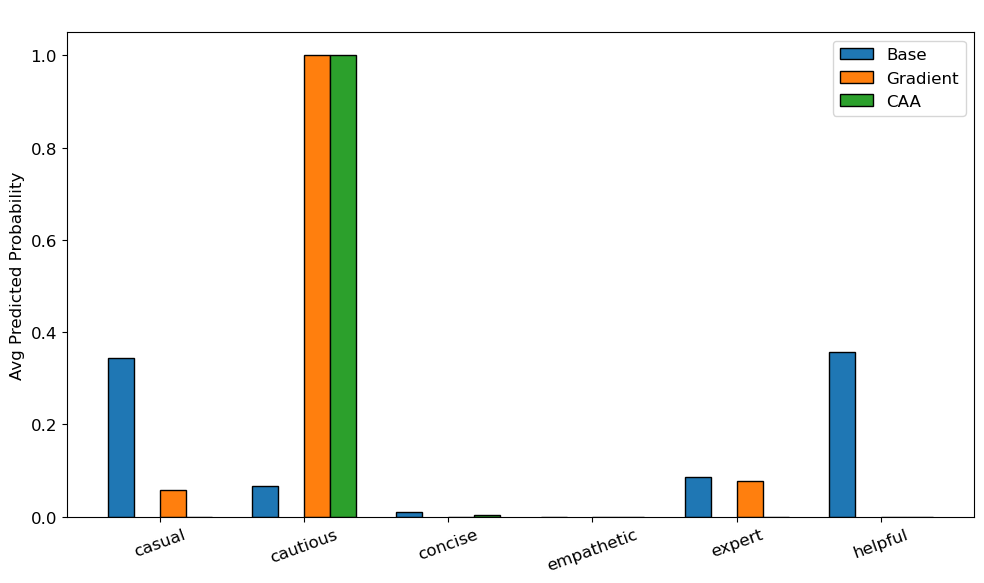

In [12]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
label_names = [f"{tone}" for tone in unique_tones]
indices = np.arange(len(label_names))
width = 0.18

plt.bar(indices - 1.5*width, avg_base,  width, label="Base", edgecolor='black')
#plt.bar(indices - 0.5*width, avg_proj,  width, label="Projection", edgecolor='black')
plt.bar(indices + 0.5*width, avg_grad,  width, label="Gradient", edgecolor='black')
plt.bar(indices + 1.5*width, avg_caa,   width, label="CAA", edgecolor='black')

plt.xticks(indices, label_names, rotation=20)
plt.ylabel("Avg Predicted Probability")
plt.title(" ")
plt.legend()
plt.tight_layout()
plt.show()

# Manual Inspection

In [13]:
def my_hook_wrapper(fwd_hook):
    def actual_hook(module, inp, out):
        if fwd_hook is None:
            return out
        else:
            return fwd_hook(module, inp, out)
    return actual_hook

def generate_with_hooks(model, tokenizer, prompt: str, layer_idx: int,
                       fwd_hook=None, max_new_tokens: int = 50):
    target_layer = model.model.layers[layer_idx]
    target_layer._forward_hooks.clear()
    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    generated = input_ids.clone()

    try:
        if fwd_hook is not None:
            actual_hook = my_hook_wrapper(fwd_hook)
            target_layer.register_forward_hook(actual_hook)

        for _ in range(max_new_tokens):
            with torch.no_grad():
                outputs = model(generated)
                next_token_logits = outputs.logits[:, -1, :]  # shape: [batch, vocab_size]
                next_token_id = next_token_logits.argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token_id], dim=1)
    finally:
        target_layer._forward_hooks.clear()

    return tokenizer.decode(generated[0], skip_special_tokens=True)

In [14]:
def get_remove_proj_hook(steer_model, target_labels=None, avoid_labels=None):
    if target_labels is None: target_labels = []
    if avoid_labels is None: avoid_labels = []
    
    def fwd_hook(module, inp, out):
        hidden_states = out[0]
        hidden_np = hidden_states.detach().cpu().numpy().astype(np.float32)
        B, S, D = hidden_np.shape
        hidden_2d = hidden_np.reshape(-1, D)
        
        new_2d = steer_model.remove_projection(hidden_2d, target_labels=target_labels, avoid_labels=avoid_labels)
        new_np = new_2d.reshape(B, S, D)
        new_hidden_torch = torch.from_numpy(new_np).to(hidden_states.device, dtype=torch.float16)
        return (new_hidden_torch,) + out[1:]
    return fwd_hook

def get_gradient_hook(steer_model, target_labels=None, avoid_labels=None, alpha=1.0):
    if target_labels is None: target_labels = []
    if avoid_labels is None: avoid_labels = []
    
    def fwd_hook(module, inp, out):
        hidden_states = out[0]
        hidden_np = hidden_states.detach().cpu().numpy().astype(np.float32)
        B, S, D = hidden_np.shape
        hidden_2d = hidden_np.reshape(-1, D)
        
        new_2d = steer_model.steer_activations(hidden_2d, 
                                               target_labels=target_labels, 
                                               avoid_labels=avoid_labels, 
                                               alpha=alpha)
        new_np = new_2d.reshape(B, S, D)
        new_hidden_torch = torch.from_numpy(new_np).to(hidden_states.device, dtype=torch.float16)
        return (new_hidden_torch,) + out[1:]
    return fwd_hook

def get_caa_hook(caa_vector, alpha=1.0):
    def fwd_hook(module, inp, out):
        hidden_states = out[0]
        hidden_np = hidden_states.detach().cpu().numpy().astype(np.float32)
        B, S, D = hidden_np.shape
        hidden_2d = hidden_np.reshape(-1, D)
        
        hidden_2d += alpha * caa_vector[None, :]
        new_np = hidden_2d.reshape(B, S, D)
        new_hidden_torch = torch.from_numpy(new_np).to(hidden_states.device, dtype=torch.float16)
        return (new_hidden_torch,) + out[1:]
    return fwd_hook

In [15]:
from datasets import load_dataset
agg_dataset = load_dataset("Narmeen07/tone_agnostic_questions", split="train")
sample_text = agg_dataset[2]["text"]
prompt = f"{sample_text}\n\n"
alpha = 5.0

LAYER_IDX = 22
max_new_tokens = 128

base_out = generate_with_hooks(model, tokenizer, prompt=prompt, 
                               layer_idx=LAYER_IDX, fwd_hook=None, 
                               max_new_tokens=max_new_tokens)

'''rp_hook_fn = get_remove_proj_hook(steer_model, target_labels=[0], avoid_labels=[1])
proj_out = generate_with_hooks(model, tokenizer, prompt=prompt, 
                               layer_idx=LAYER_IDX, fwd_hook=rp_hook_fn, 
                               max_new_tokens=max_new_tokens)'''

grad_hook_fn = get_gradient_hook(steer_model, target_labels=[4], avoid_labels=[0], alpha=1200)
grad_out = generate_with_hooks(model, tokenizer, prompt=prompt, 
                               layer_idx=LAYER_IDX, fwd_hook=grad_hook_fn, 
                               max_new_tokens=max_new_tokens)

caa_hook_fn = get_caa_hook(caa_vec_B, alpha=alpha)
caa_out = generate_with_hooks(model, tokenizer, prompt=prompt, 
                              layer_idx=LAYER_IDX, fwd_hook=caa_hook_fn, 
                              max_new_tokens=max_new_tokens)

print("\n--- BASE (UNSTEERED) ---\n", base_out)
print("\n--- GRADIENT STEP ---\n", grad_out)
print("\n--- CAA ---\n", caa_out)


--- BASE (UNSTEERED) ---
 What can I do if I feel my mental health is deteriorating despite seeking help?

If you feel your mental health is deteriorating despite seeking help, there are several things you can do:

1. Seek professional help: The first step is to seek professional help from a mental health professional, such as a therapist or psychiatrist. They can help you identify the root cause of your mental health issues and develop a treatment plan.

2. Practice self-care: Taking care of yourself is essential for maintaining good mental health. This includes getting enough sleep, eating a healthy diet, exercising regularly, and engaging in activities that bring you joy and relaxation.

3. Connect with others: Social support is crucial for mental health. Reach out to friends

--- GRADIENT STEP ---
 What can I do if I feel my mental health is deteriorating despite seeking help?

 If you feel your mental health is deteriorating despite seeking help, there are several things you can 